## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


## Portfolio Exercise 01

# Diabetes prediction

We will again work with data from the NHANES study. But this time we aim to predict something which is a little less dramatic compared to 10-year survival. We want to predict if a patient has **diabetes** or not.

The goal of this portfolio exercise is to complete a full machine learning task from data import to model training an optimization until a final model evaluation.

Good luck!

<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
#!pip install lifelines

In [2]:
import os
import shap
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Portfolio exercises:
### 1. load and inspect the data 
- what are missing/problematic entries?

### 2. data cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/benefitial)

### 3. inspect correlations among the features 
- which features do you expect to play a role for a later machine learning model (for predicting diabetes), and why?

### 4. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

### 5. Train a first model (random forest)
- use validation and training set to avoid overfitting
- optimize your hyperparameters with a simple grid search
- Evaluate the model using accuracy, confusion matrix, f1-score, and ROC curve
- How good is the model? What are the main problems?


### 6. Check if labels are balanced
- If you find that the data is not balanced enough, try to mitigate this problem (e.g. by oversampling or adding class weights).
- Use any hyperparameter search strategy you know (grid search, random search, or Bayesian search)
- Again use the same evaluation metrics as above to inspect the quality of your model.


### 7. Explainability
- Use SHAP to plot the importance of each feature for the predictions
- Use SHAP for two individual predictions (one person with diabetes predicted, one person with lower risk)

- Small check: Train another model (same hyperparameters), but remove the data of the 10 least important features. How does this affect your model performance?

### 8. Conclusion
- How good is your model? How well can you predict diabetes?
- Could such a model be improved further? If so, what could be done to improve the model?
- Compare your results to current research [Dinh et al., 2019](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0918-5). Obviously, it is not 100% the same data, but somewhat comparable. Two specific questions to answer: Is your model of comparable type to what they used in their study? And did you get a comparable model performance?


Another article (optional, if you're interested): [Vangeepuram et al., 2021](https://www.nature.com/articles/s41598-021-90406-0#Tab1) 



## Final submission:
Please address all the above mentioned points in this notebook (e.g., using text cells where needed for explanations or answers).

<a name='1'></a>
## 1. The Dataset

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

This time we will work with data from the period 2017-2018 which was downloaded via the pip package `nhanes` [GitHub link](https://github.com/poldrack/nhanes).

Most features are described within the GitHub repository. Some important information on the provided features:

- `Gender` - 1 is female, 0 is male
- `diabetes` - 1 means diabetes was diagnosed
- `diabetes_borderline` - 1 means "borderline diabetes" (close to having diabetes) was diagnosed
- `Smoking` - 1 means person has smoked within the last 5 days. People with missing entries were set to 0
- `PhysicalActivity` - 0 means no particular activities, 1 means "moderate recreational activities" or walking, biking and 2 means more extensive recreational activities
- `SEQN` is an ID


### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?



In [3]:
path_data = "../data/" # add your own path

In [4]:
filename = "NHANES_2017_2018_diabetes.csv"
data = pd.read_csv(os.path.join(path_data, filename))

In [5]:
data.head()

,SEQN,Gender,AgeInYearsAtScreening,HaveSeriousDifficultySeeing,HaveSeriousDifficultyHearing,WeightKg,StandingHeightCm,BodyMassIndexKgm2,BloodMercuryTotalUgl,BloodManganeseUgl,...,TotalSugarsGm_DR1TOT,BloodLeadUgdl,60SecPulse30SecPulse2,DirectHdlcholesterolMgdl,TotalCholesterolMgdl,SystolicBloodPres2NdRdgMmHg,Smoking,PhysicalActivity,diabetes,diabetes_borderline
0,93703.0,1,2.0,0.0,0.0,13.7,88.6,17.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0
1,93704.0,0,2.0,0.0,0.0,13.9,94.2,15.7,0.47,9.41,...,76.97,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0
2,93705.0,1,66.0,0.0,0.0,79.5,158.3,31.7,1.07,8.57,...,91.55,2.98,52.0,60.0,157.0,NaN,0,1.0,0,0
3,93706.0,0,18.0,0.0,0.0,66.3,175.7,21.5,10.64,14.07,...,14.73,0.74,82.0,47.0,148.0,114.0,0,1.0,0,0
4,93707.0,0,13.0,0.0,0.0,45.4,158.4,18.1,0.20,12.60,...,84.22,0.39,100.0,68.0,189.0,128.0,0,0.0,0,0


---

### 1. load and inspect the data 
- what are missing/problematic entries?

The next codeblock shows the number of null entries for every column. We can't say for sure if these features were diagnosed or not:

In [6]:
data.isnull().sum()

SEQN                                          0
Gender                                        0
AgeInYearsAtScreening                         0
HaveSeriousDifficultySeeing                   1
HaveSeriousDifficultyHearing                  1
WeightKg                                    124
StandingHeightCm                            350
BodyMassIndexKgm2                           361
BloodMercuryTotalUgl                        853
BloodManganeseUgl                           853
BloodSeleniumUgl                            853
BloodCadmiumUgl                             853
AnnualFamilyIncome                         1034
AlcoholGm_DR1TOT                           1081
CholesterolMg_DR1TOT                       1081
TotalPolyunsaturatedFattyAcidsGm_DR1TOT    1081
TotalMonounsaturatedFattyAcidsGm_DR1TOT    1081
TotalSaturatedFattyAcidsGm_DR1TOT          1081
TotalFatGm_DR1TOT                          1081
TotalSugarsGm_DR1TOT                       1081
BloodLeadUgdl                           

---

### 2. data cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/benefitial)

It is better to clean the data from these null values. This way we train the model only on diagnoses, that we are certain about.

In [7]:
print("Shape of full dataset: ", data.shape)
data_cleaned = data.dropna()
print("Dropping all null values reduces the data to", data_cleaned.shape)

Shape of full dataset:  (8366, 29)
Dropping all null values reduces the data to (4905, 29)


As we can see dropping all null values reduces the data significantly and less data will result in a worse model. But it will still result in abetter model, than trying to predict an outcome on random data. Filling these values would be no good idea either, since we can't extrapolate diagnoses from the other features.

---

### 3. inspect correlations among the features 
- which features do you expect to play a role for a later machine learning model (for predicting diabetes), and why?

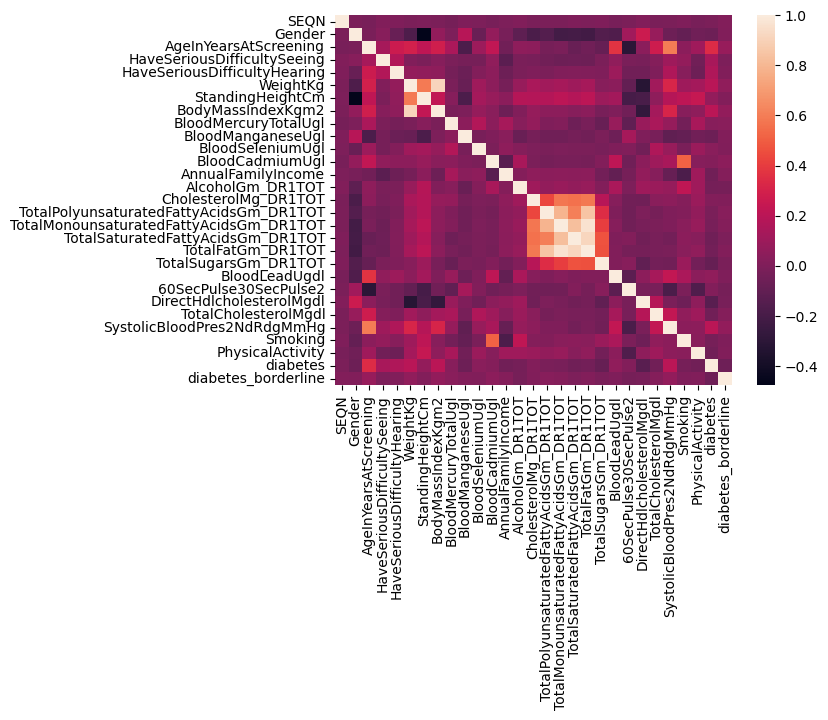

In [8]:
sns.heatmap(data_cleaned.corr(), xticklabels=True, yticklabels=True)
plt.show()

The correlation matrix shows high correlations where the squares are brighter. We can see that the Body Mass Index has high correlations to WeightKG and StandingHeightCm for the obvious reason that it is the ratio of the two. 
I expect features that have high correlations with the diabetes row to have high importance for the model. Age has the highest correlation. Also Body Mass Index and WeightKG have high correlations with diabetes, but StandingHeightCm has not. This could mean that WeightKG is the decisive factor of the BMI correlation.SystolicBloodPres2NdRdgMmHg has also a high correlation.
There might also be interactions between two or more features leading to diabetes, which is not visible in the correlation matrix. For example DirectHdlcholestrolMgdl has low correltion with diabetes but may have a high impact in combination with another feature. After all, one reason to train a model is to find these hidden interactions.


---
### 4. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%


In [9]:
# seperate labels
y = data_cleaned['diabetes']
# seperate data
X = data_cleaned.drop(['diabetes'], axis=1)

In [10]:
# split train and test data into 70% and 30% respectively
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=42)
# split the 30% test data into 15% and 15% for validation and test respectively
y_test, y_val, X_test, X_val = train_test_split(y_test, X_test, test_size=0.5, random_state=42)

# check the distribution after the split
print(X_test.shape, X_val.shape, X_train.shape)
print(y_test.shape, y_val.shape, y_train.shape)

print("Train data share: ", y_train.shape[0] / y.shape[0])
print("Test data share: ", y_test.shape[0] / y.shape[0])
print("Validation data share: ", y_val.shape[0]/ y.shape[0])

(736, 28) (736, 28) (3433, 28)
(736,) (736,) (3433,)
Train data share:  0.6998980632008155
Test data share:  0.15005096839959225
Validation data share:  0.15005096839959225


---
### 5. Train a first model (random forest)
- use validation and training set to avoid overfitting
- optimize your hyperparameters with a simple grid search
- Evaluate the model using accuracy, confusion matrix, f1-score, and ROC curve
- How good is the model? What are the main problems?

#### <a id='first_training'>5.1 First Training</a>

We will train a first model with some parameters to see what is possible with our data.

In [11]:
# train model
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [12]:
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

In [13]:
y_train_preds = model.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = model.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.903518057135725
Val C-Index: 0.8544969869579564


#### 5.2 First grid search

In [14]:
from sklearn.model_selection import GridSearchCV

def perform_and_plot_RNDForest_grid_search(parameters: dict, train_data, train_labels):
    model = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(model, parameters, verbose=0)
    grid_search.fit(train_data, train_labels)
    
    # Collect grid search results
    cv_results = grid_search.cv_results_
    mean_test_scores = cv_results['mean_test_score']
    params = cv_results['params']

    # Prepare data for plotting
    scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                    len(parameters['min_samples_leaf']),
                                                    len(parameters['n_estimators']))

    # Create a line plot for each n_estimators
    fig, ax = plt.subplots(figsize=(10, 6))

    for k, n_estimators in enumerate(parameters['n_estimators']):
        scores_for_n_estimators = scores_array[:, :, k].T
        for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
            ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                    marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

    ax.set_title('Grid Search Results')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Mean Test Score')
    ax.legend(loc='best')

    plt.show()
    
    return grid_search

#### 5.3 Second grid search

The parameters 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50 and performed best in our grid search. We are testing some more parameters around these values in the next grid search, to see if we can get even better results.

#### 5.4 Final Prarameters

The parameters 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 40 performed even better, but not much. We can narrow down the parameters even more or look for completly different ones, but we might not make a big difference in mean test score. We will stick to the parameters we found in this grid search.

In [15]:
# train model
model = RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=40, random_state=42)
model.fit(X_train, y_train)

y_train_preds = model.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = model.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9961347856490216
Val C-Index: 0.8680860670684056


We were able to get a higher C-index compared to our [first training](#first_training) (0.868 compared to 0.854). But its not much. We can see that the model is still overfitting, because the training score is higher than the validation score. We can try to reduce the overfitting by reducing the max_depth and min_samples_leaf. But we will not get a much better model, because the validation score is already high.

#### 5.5 Evaluation

- Evaluate the model using accuracy, confusion matrix, f1-score, and ROC curve
- How good is the model? What are the main problems?

##### helper functions

In [16]:
from sklearn import metrics

def plot_confusion_matrix(confusion_matrix):
    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(6, 4), dpi=50)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},
               cmap="Purples",
               fmt="g")

    # Set labels and title
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Show the plot
    plt.show()
    
    
def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()


def evaluate_model(model, X_validation, y_validation):
    y_predicted = model.predict(X_validation)
    y_probability = model.predict_proba(X_val)[:,1]
    
    print(f"C-Index   :  {cindex(y_validation.values, y_probability)}")
    
    stupid_predictions = np.zeros(len(y_validation))

    accuracy = metrics.accuracy_score(y_validation, stupid_predictions)
    print("Baseline  : ", accuracy)
    accuracy = metrics.accuracy_score(y_validation, y_predicted)
    print("Accuracy  : ", accuracy)
    
    print("f1 sore   : ", metrics.f1_score(y_validation, y_predicted))
    
    #print("Condusion matrix: ")
    plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_validation, y_predicted))
    
    #print("ROC curve: ")
    plot_roc_curve(y_validation, y_predicted)    
    
    plot_roc_curve(y_val, y_probability)
    print("Probability mean: ", y_probability.mean())

##### Evaluation

C-Index   :  0.8680860670684056
Baseline  :  0.8790760869565217
Accuracy  :  0.8872282608695652
f1 sore   :  0.1443298969072165


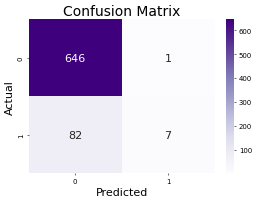

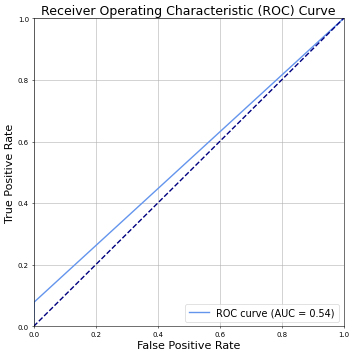

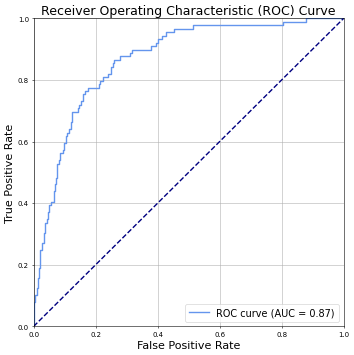

Probability mean:  0.11266842407109834


In [17]:
evaluate_model(model, X_val, y_val)

The model is not very good at predicting diabetes. We can see that its accuracy is not much better than just guessing that nobody has diabetes.
The confusion matrix shows that the model is focusing on keeping the false positive predictions low. But we get a lot of false negatives and only 7 true negatives. So it is not predicting diabetes very good.
The f1-score is very low for predicting diabetes.
The ROC curve shows that the model is not very good at predicting diabetes. The AUC is 0.5, which means that the model is not better than random guessing.


---
### 6. Check if labels are balanced
- If you find that the data is not balanced enough, try to mitigate this problem (e.g. by oversampling or adding class weights).
- Use any hyperparameter search strategy you know (grid search, random search, or Bayesian search)
- Again use the same evaluation metrics as above to inspect the quality of your model.

Probability mean:  0.11266842407109834


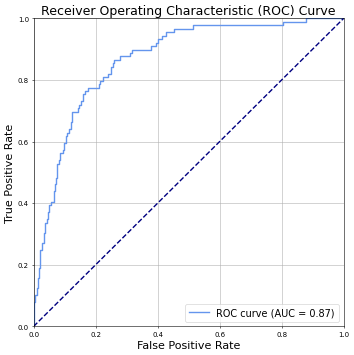

In [18]:

y_proba = model.predict_proba(X_val)[:,1]
print("Probability mean: ", y_proba.mean())
plot_roc_curve(y_val, y_proba)

---
### 7. Explainability
- Use SHAP to plot the importance of each feature for the predictions
- Use SHAP for two individual predictions (one person with diabetes predicted, one person with lower risk)

- Small check: Train another model (same hyperparameters), but remove the data of the 10 least important features. How does this affect your model performance?


---
### 8. Conclusion
- How good is your model? How well can you predict diabetes?
- Could such a model be improved further? If so, what could be done to improve the model?
- Compare your results to current research [Dinh et al., 2019](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0918-5). Obviously, it is not 100% the same data, but somewhat comparable. Two specific questions to answer: Is your model of comparable type to what they used in their study? And did you get a comparable model performance?